In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cmocean
from flow import sample_images
from transforms_jax import radon
from utils import load_checkpoint
from torchdiffeq import odeint
import time
from torch import optim
from torchmetrics import CatMetric
from unet import Unet


/home/johnma/d-flow/venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:

torch.manual_seed(159753)
np.random.seed(159753)

torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.backends.cuda.enable_math_sdp(True)


In [4]:

%%capture
checkpoint_path = 'ckp_6375.tar'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Unet().to(device)

ema_model = torch.optim.swa_utils.AveragedModel(
    model, multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(0.9999)
)
_, _, model, _, _, ema_model  = load_checkpoint(model=model, ema_model=ema_model, path=checkpoint_path)
model.eval()

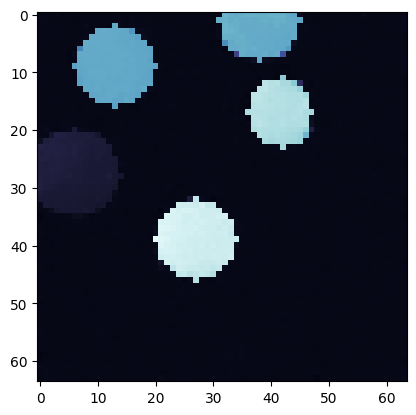

In [5]:
# test model out quickly
img = sample_images(model, (1,1,64,64), num_steps=2)
img = img[-1].squeeze().cpu().numpy()
plt.imshow(img, cmap=cmocean.cm.ice)

(91, 91)


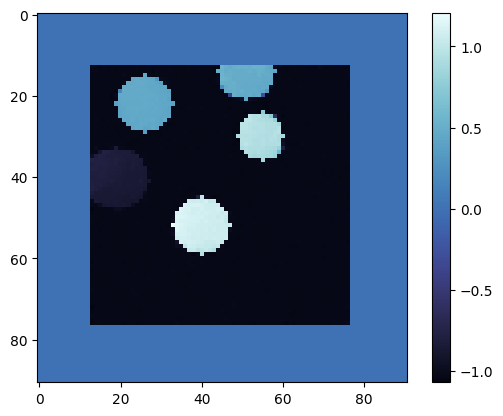

In [8]:
img_padded = radon.pad_image(img)
plt.imshow(img_padded, cmap=cmocean.cm.ice)
plt.colorbar()
print(img_padded.shape)

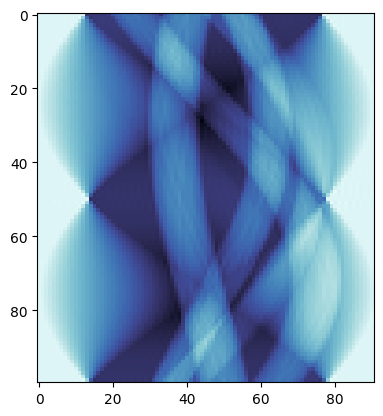

In [6]:
N = 100 # number of projection angles
img_radon = radon.radon_transform(img, N=N)
img_radon.shape
plt.imshow(img_radon.real, cmap=cmocean.cm.ice) # high angular sampling rate

/home/johnma/d-flow/transforms_jax/interp.py:77: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = jnp.array([param] * ndim, coord.dtype)
/home/johnma/d-flow/transforms_jax/interp.py:77: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = jnp.array([param] * ndim, coord.dtype)


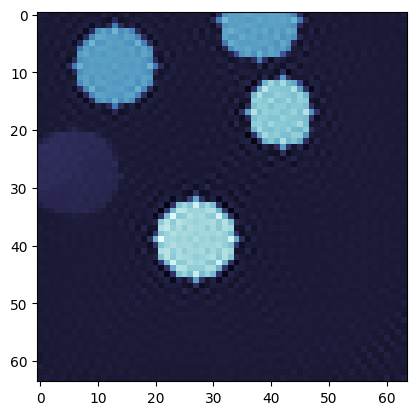

In [14]:
# demonstrate backprojection
img_backproj = radon.iradon_transform(img_radon)
plt.imshow(img_backproj.real, cmap=cmocean.cm.ice) # high angular sampling

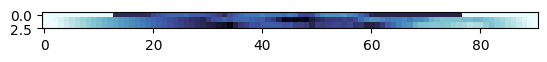

In [15]:
# try again with a lower angular sampling rate
N = 3
img_radon = radon.radon_transform(img, N=N)
img_radon.shape
plt.imshow(img_radon.real, cmap=cmocean.cm.ice) 

/home/johnma/d-flow/transforms_jax/interp.py:77: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = jnp.array([param] * ndim, coord.dtype)
/home/johnma/d-flow/transforms_jax/interp.py:77: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = jnp.array([param] * ndim, coord.dtype)


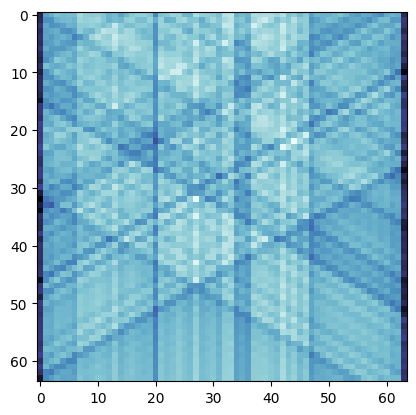

In [16]:
# demonstrate backprojection
img_backproj = radon.iradon_transform(img_radon)
plt.imshow(img_backproj.real, cmap=cmocean.cm.ice) # high angular sampling

## D-flow algorithm
- initialize $x_0$, either using variance preserving blend, or just sampling $x_0 \sim p_0$. 
- solve the flow ode with $u_t, x_0$.
- perform an optimization step:
$$
\min_{x_0 \in \mathbb{R}^d} \mathcal{L}(\psi_1(x_0)).
$$
- optimization is done with LBFGS (limited memory BFGS).

In [17]:
from typing import Callable, Dict, List, Optional


def inverse_loss_fn(x, y):
    """
    Loss function for the inverse problem.
    """
    x = x.float()
    y = y.float()
    
    # Radon transform
    x_radon = radon.radon_transform(x, N=N)
    
    # Compute the loss
    loss = torch.mean((x_radon - y) ** 2)
    
    return loss

def ode_integrate(ode_func: Callable,
                  init_x: torch.Tensor,
                  ode_opts: Dict = {},
                  shape: Optional[tuple] = (1,1, 64, 64),
                  t_eps: float = 0,
                  init_t: float = 0.,
                  final_t: float = 1.,
                  t_arr: Optional[List[float]] = None,
                  intermediate_points: bool = False
      ) -> torch.Tensor:

    """Integrates an ODE using the given ode_func.

    Args:
        ode_func: model wraper to use for the ODE. Expected API: ode_func(x,t) -> torch.Tensor
        init_x: The initial state of the ODE.
        ode_opts: A dictionary of options for the ODE solver.
        t_eps: A small value to add to the initial time.
        init_t: The initial time.
        final_t: The final time.
        t_arr: An optional array of times to evaluate the ODE at.
        intermediate_points: Whether to return the intermediate points.

    Returns:
        The solution to the ODE at the final time. (or at intermediate points if intermediate_points=True)
    """

    if t_arr is None:
        t = torch.FloatTensor([init_t-t_eps, final_t]).to(init_x.device)
    else:
        t = torch.FloatTensor(t_arr).to(init_x.device)

    z = odeint(
        func = lambda t, x: model(x, t.repeat(shape[0])),
        y0 = init_x,
        t = t,
        **{"atol": 1e-5, "rtol": 1e-5, **ode_opts}
    )
    if not intermediate_points:
        z = z[-1]
    return z

In [ ]:
loss = 0
start_time = time.time()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

init_x = torch.randn((1, 1, 64, 64), device=device, dtype=torch.float32)
init_x.requires_grad = True

x1_trajectory = []
x1 = ode_integrate(
    ode_func=model,
    init_x=init_x,
    shape = (1, 1, 64, 64)
)
x1_trajectory.append(x1.detach().cpu().numpy())
max_iter = 1000
optim_steps = 100
target_cost = .1
time_limit = 10
lr = 0.1
optimizer = optim.LBFGS([init_x], max_iter=max_iter, lr=lr, line_search_fn='strong_wolfe', history_size=10)
metrics = {'loss': CatMetric(), 'cost': CatMetric(), 'reg': CatMetric(), 'norm_x0': CatMetric(), 'std_x0': CatMetric(), 'mean_x0': CatMetric(), 'time': CatMetric()}
for step in range(optim_steps):

    def closure():
        nonlocal loss
        nonlocal x1
        optimizer.zero_grad()

        reg_loss = torch.tensor(0.).to(init_x)

        ### solve for x1
        x1 = ode_integrate(ode_func=model, init_x =init_x)
        
        degraded_x1 = H(x1)
        cost = inverse_loss_fn(degraded_x1, y)
        loss = cost 

        norm_x0 = init_x.norm()
        std_x0 = init_x.std()
        mean_x0 = init_x.mean()

        metrics['norm_x0'].update(norm_x0.item())
        metrics['std_x0'].update(std_x0.item())
        metrics['mean_x0'].update(mean_x0.item())
        metrics['cost'].update(cost.item())
        metrics['reg'].update(reg_loss.item())
        metrics['loss'].update(loss.item())

        loss.backward()

        return loss


    optimizer.step(closure)

    x1_trajectory.append(x1.detach().cpu().numpy())


    elapsed = time.time() - start_time
    metrics['time'].update(elapsed)

    if step % 5 == 0:
        elapsed = elapsed/60
        print(f"[Step {step}] Loss {loss.item()}"
            + f"| x_init min {init_x.detach().min()} max {init_x.detach().max()}" + f"| time: {elapsed} mins")


    if target_cost is not None:
        mets_cost = metrics['cost'].compute()
        if mets_cost.dim() > 0:
            mets_cost = mets_cost[-1]
        last_cost = mets_cost.item()
        if last_cost <= target_cost:
            print(f'reached cost of {last_cost}')
            break

    if time_limit is not None:
        elapsed = (time.time() - start_time)/60 # time in minutes
        if elapsed > time_limit:
            print(f'reached time limit of {time_limit} mins')
            break

with torch.no_grad():
    x1 = ode_integrate(model, init_x)
x1_trajectory.append(x1.detach().cpu().numpy())



OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 47.37 GiB of which 1.69 MiB is free. Including non-PyTorch memory, this process has 47.36 GiB memory in use. Of the allocated memory 11.31 GiB is allocated by PyTorch, and 5.34 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)